# Praxisbeispiel Katzen vs. Hunde
In diesem Jupiternotebook wird Schritt für Schritt erläutert, wie man mithilfe von Tensorflow,
Neuronale Netzwerke erstellt, trainiert und bewertet sowie Daten lädt und für das Training vorbereitet.

## I. Import der notwendigen Module


- ``tensorflow`` und ``keras`` für das Neuronale Netzwerk
- ``Matplolib`` für das Anzeigen von Bildern und Grafiken

In [54]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline 
from typing import List
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D
import os
import numpy as np

ImageDataGenerator = keras.preprocessing.image.ImageDataGenerator
os.chdir(r'C:\Users\nic-e\Datasets\PetImages')

## II. Laden und Untersuchen des Datensatzes
- Dieser beinhaltet ``Bilder`` von ``Hunden`` und ``Katzen``
- Zu jedem Bild gibt es ein ``Label`` das angibt welches der beiden Tiere auf dem Bild zu sehen ist.
- ``0`` steht dabei für eine Katze
- ``1`` steht für einen Hund

Metadaten:
- Insgesamt 25000
- 12.500 Bilder von Katzen
- 12.500 Bilder von Hunden

- Bilder haben 3 Farbchannels (RGB)

#### Untersuchen der Daten
Virtuelle darstellung der Bilder

<img src="./images/rgb_layers.png" alt="Alt text that describes the graphic" title="Title text" style="width:500px;height:300px" />

In [55]:
images = []
for i in range(10):
  im = img.imread('Cat/{}.jpg'.format(i))
  images.append(im)
  print('image shape', im.shape, 'maximum color level', im.max())

image shape (375, 500, 3) maximum color level 255
image shape (281, 300, 3) maximum color level 239
image shape (397, 312, 3) maximum color level 255
image shape (415, 500, 3) maximum color level 255
image shape (375, 500, 3) maximum color level 255
image shape (144, 176, 3) maximum color level 255
image shape (304, 400, 3) maximum color level 255
image shape (500, 495, 3) maximum color level 255
image shape (346, 461, 3) maximum color level 255
image shape (426, 320, 3) maximum color level 249


#### Data cleaning

Bevor man mit den Daten arbeitet, muss man sicherstellen das die Qualität der Daten auch ensprechend den Anforderungen ist.

Der Datensatz enthält einige Bilder die nichts mit dem Datensatz zutun haben.

In [56]:
bad_dog_ids = [5604, 6413, 8736, 8898, 9188, 9517, 10161, 
               10190, 10237, 10401, 10797, 11186]

bad_cat_ids = [2939, 3216, 4688, 4833, 5418, 6215, 7377, 
               8456, 8470, 11565, 12272]

In [57]:
def load_images(ids, categ):
  '''return the images corresponding to a list of ids'''
  images = []
  dirname = categ+'s' # dog -> dogs
  for theid in ids: 
    fname = '{categ}/{theid}.jpg'.format(
        dirname=dirname,
        categ=categ, 
        theid=theid
    )
    im = img.imread(fname)
    images.append(im)
  return images

bad_dogs = load_images(bad_dog_ids, 'dog')
bad_cats = load_images(bad_cat_ids, 'cat')

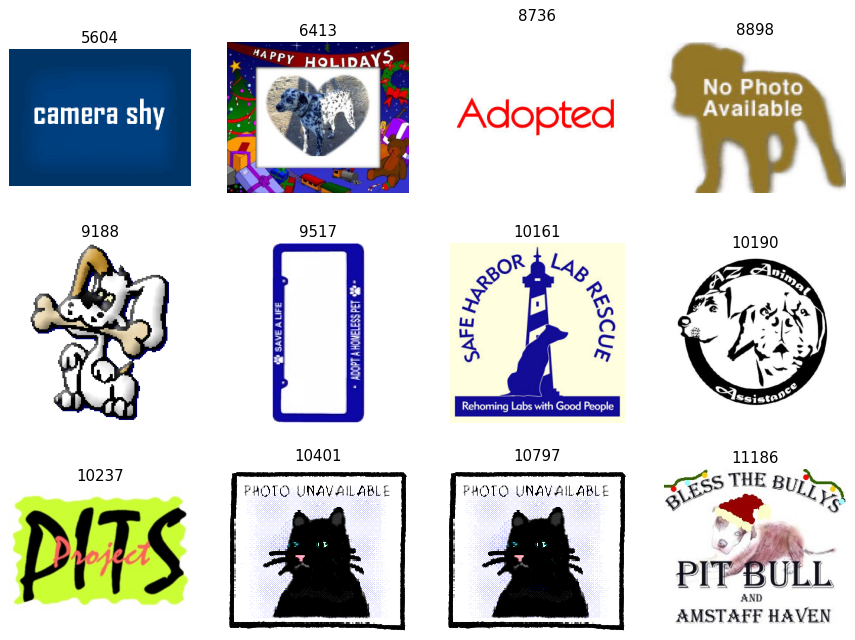

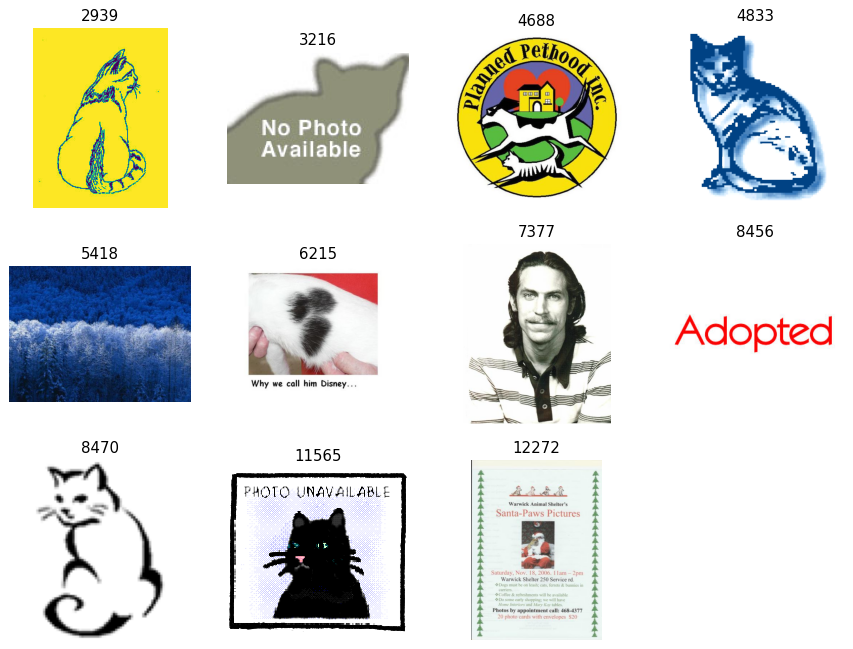

In [58]:
def plot_images(images, ids):
    ncols, nrows = 4, 3
    fig = plt.figure( figsize=(ncols*3, nrows*3), dpi=90)
    for i, (img, theid) in enumerate(zip(images,ids)):
      plt.subplot(nrows, ncols, i+1)
      plt.imshow(img)
      plt.title(str(theid))
      plt.axis('off')

plot_images(bad_dogs, bad_dog_ids)
plot_images(bad_cats, bad_cat_ids)

### Data Preprocessing und Laden
- Die Bilder Brauchen eine einheitliche Größe, damit das Neuronale Netzwerk darauf konfiguriert werden kann.

Hierfür definieren wir ein Funktion die über die Daten iteriert und alle bilder auf die Gleiche `Höhe` und `Breite` skaliert.

Des weiteren werden die Bilder in Gruppen von jeweils 32 Bildern zusammengefasst. Diese Gruppen nennt man einen ``batch``.

<img src="./images/Batch.png" alt="Alt text that describes the graphic" title="Title text" style="width:900px;height:450px" />

Dies ist von Vorteil, da hier nicht nach jedem Bild Backpropagation angewendet wird, sondern erst nach ausrechnen eines gesamten Batches. Dies Beschläuning das Traning um ein vielfaches und kann auch positiv für die Generalisierung des neuronales Netzwerkes sein.

In [59]:
os.chdir(r'C:\Users\nic-e\Datasets\PetImages_cleaned')
BATCH_SIZE = 32
HEIGHT, WIDTH = (256,256)

img_generator = ImageDataGenerator(
    rescale = 1/255., 
    horizontal_flip = True, 
    zoom_range = 0.3, 
    rotation_range = 15.,
    validation_split = 0.2,
)

train_dataset = img_generator.flow_from_directory(
    os.getcwd(),
    target_size = (HEIGHT, WIDTH), 
    classes = ('Dog','Cat'),
    batch_size = BATCH_SIZE,
    subset = 'training'
)

val_dataset = img_generator.flow_from_directory(
    os.getcwd(),
    target_size = (HEIGHT, WIDTH), 
    classes = ('Dog','Cat'),
    batch_size = BATCH_SIZE,
    subset = 'validation'
)

Found 19980 images belonging to 2 classes.
Found 4994 images belonging to 2 classes.


In [60]:
batch = train_dataset.next()
print(f'Der Batch hat {len(batch)} Elemente') # how many elements does the batch have
print(f'Die Daten haben folgende Dimensionen: {batch[0].shape}')
print(f'Die Daten haben folgenden Datentyp: {batch[0].dtype}')
print(f'Die Labels haben folgende Dimensionen: {batch[1].shape}')
print(f'Die labels haben den folgenden Datentyp: {batch[1].dtype}')

Der Batch hat 2 Elemente
Die Daten haben folgende Dimensionen: (32, 256, 256, 3)
Die Daten haben folgenden Datentyp: float32
Die Labels haben folgende Dimensionen: (32, 2)
Die labels haben den folgenden Datentyp: float32


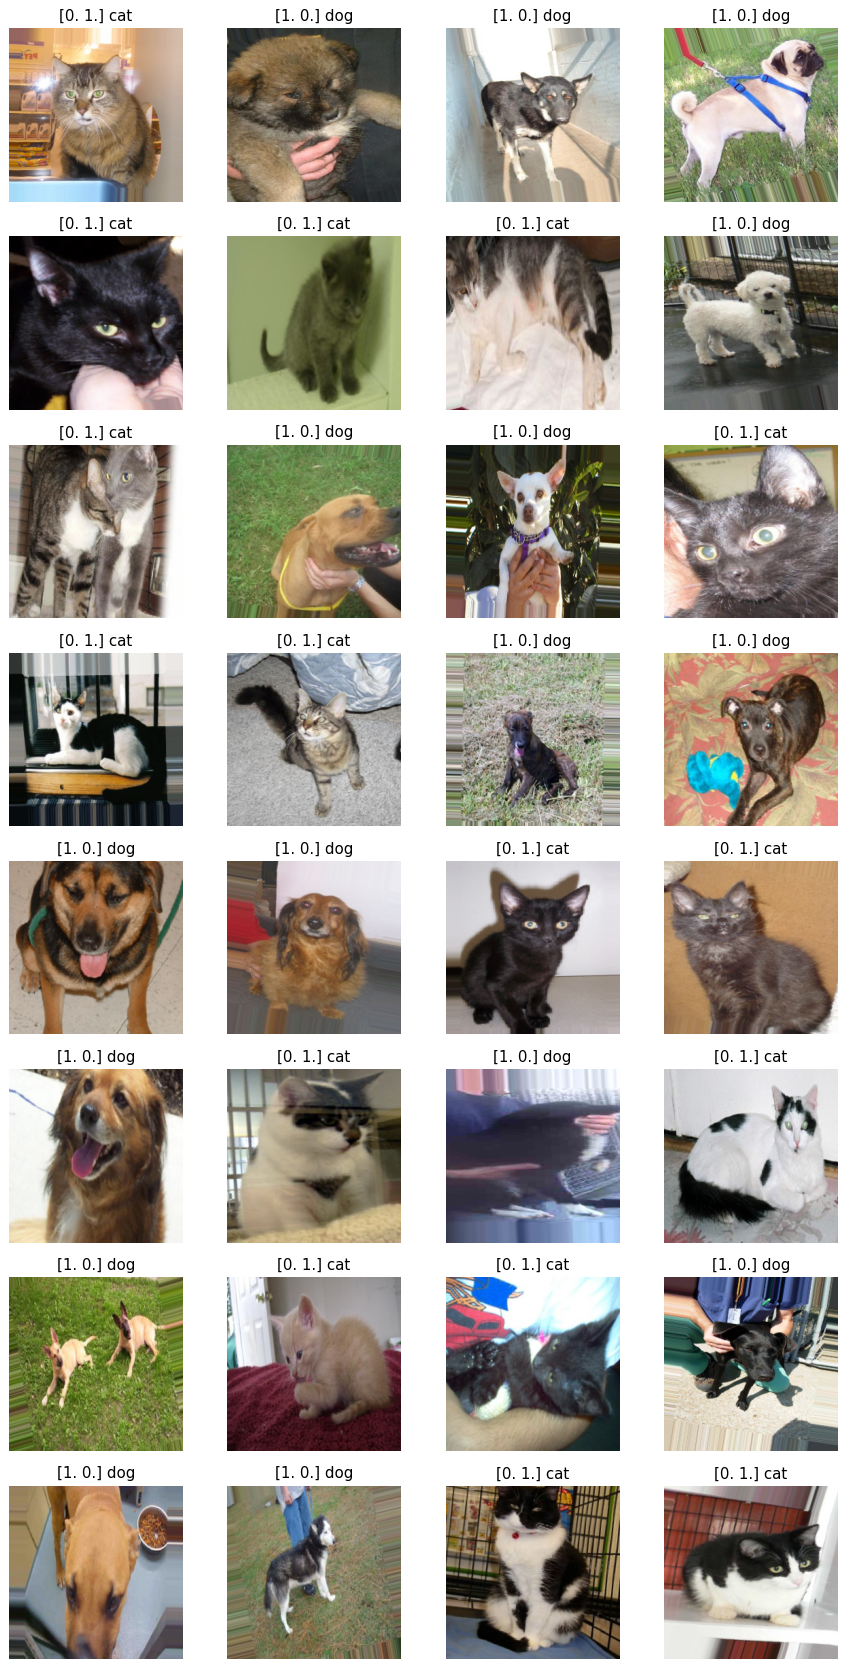

In [61]:
def plot_images(batch):
    imgs = batch[0]
    labels = batch[1]
    ncols, nrows = 4,8
    fig = plt.figure( figsize=(ncols*3, nrows*3), dpi=90)
    for i, (img,label) in enumerate(zip(imgs,labels)):
      plt.subplot(nrows, ncols, i+1)
      plt.imshow(img)
      assert(label[0]+label[1]==1.)
      categ = 'dog' if label[0]>0.5 else 'cat'
      plt.title( '{} {}'.format(str(label), categ))
      plt.axis('off')

plot_images(train_dataset.next())

## Erstellen des Neuronalen Netzwerks

#### Dense Layer
<img src="./images/Dense_Layer.png" alt="Alt text that describes the graphic" title="Title text" style="width:600px;height:300px" />

#### Convolutional Layer
<img src="./images/Convolutional_Layer.png" alt="Alt text that describes the graphic" title="Title text" style="width:900px;height:450px" />

#### Kernel
<img src="./images/ConvolutionII.png" alt="Alt text that describes the graphic" title="Title text" />

#### Max Pooling Layer
<img src="./images/MaxPoolingLayer.png" alt="Alt text that describes the graphic" title="Title text" />



In [62]:
def get_model():
    model = keras.models.Sequential()

    model.add( 
        keras.layers.Conv2D(
            24, 5, input_shape=(256,256,3), 
            activation='relu', 
        )
    )
    model.add(MaxPooling2D(2))
    model.add(Conv2D(48, 5, activation='relu',))
    model.add(MaxPooling2D(2) )
    model.add(Conv2D(96, 5, activation='relu',))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(0.9))
    model.add(keras.layers.Dense(2, activation='softmax',))

    # Print a summary of the model and compile it
    model.summary()
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adamax(lr=0.001), metrics=['acc'])    
    return model

# Trainieren des Models

- das Modell wird trainiert und die Trainingshistorie wird gespeichert

In [63]:
model = get_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 252, 252, 24)      1824      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 126, 126, 24)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 122, 122, 48)      28848     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 61, 61, 48)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 57, 57, 96)        115296    
                                                                 
 flatten_1 (Flatten)         (None, 311904)           

c:\Users\nic-e\OneDrive\Dokumente\GitHub\Cats_vs_Dogs_nn\venv\lib\site-packages\keras\optimizer_v2\adamax.py:90: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


In [64]:
history = model.fit_generator(
    train_dataset, 
    validation_data = val_dataset,
    workers=24,
    epochs=20,
)

C:\Users\nic-e\AppData\Local\Temp/ipykernel_5240/2405436493.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/20
409/625 [==================>...........] - ETA: 11s - loss: 0.6674 - acc: 0.5768

c:\Users\nic-e\OneDrive\Dokumente\GitHub\Cats_vs_Dogs_nn\venv\lib\site-packages\PIL\TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 51s 67ms/step - loss: 0.6441 - acc: 0.6103 - val_loss: 0.5490 - val_acc: 0.7157
Epoch 2/20
625/625 [==============================] - 37s 58ms/step - loss: 0.5580 - acc: 0.7141 - val_loss: 0.5235 - val_acc: 0.7309
Epoch 3/20
625/625 [==============================] - 37s 59ms/step - loss: 0.5137 - acc: 0.7490 - val_loss: 0.4875 - val_acc: 0.7721
Epoch 4/20
625/625 [==============================] - 37s 58ms/step - loss: 0.4791 - acc: 0.7714 - val_loss: 0.4783 - val_acc: 0.7765
Epoch 5/20
625/625 [==============================] - 37s 58ms/step - loss: 0.4528 - acc: 0.7904 - val_loss: 0.4384 - val_acc: 0.8032
Epoch 6/20
625/625 [==============================] - 37s 58ms/step - loss: 0.4405 - acc: 0.7954 - val_loss: 0.4131 - val_acc: 0.8162
Epoch 7/20
625/625 [==============================] - 37s 58ms/step - loss: 0.4197 - acc: 0.8091 - val_loss: 0.4027 - val_acc: 0.8268
Epoch 8/20
625/625 [==============================] - 37s 58ms/step - los

### Ladet eure Bilder für eine Klassifizierung hoch!
<img src="./images/QR_Code_NEW.png" alt="Alt text that describes the graphic" title="Title text" style="width:300px;height:300px" />

# Trainigshistorie

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


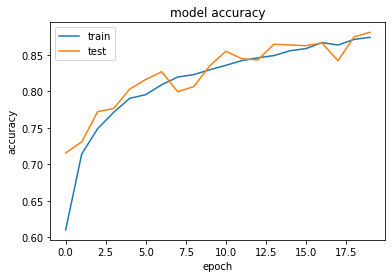

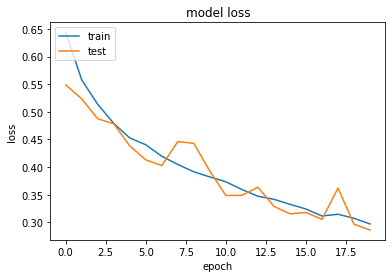

In [65]:

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Validierung des Traininerten Netzwerks

In [71]:
os.chdir(r'C:\Users\nic-e\OneDrive\DHBW\Software-Engineering-AI-Presentation\Validation_Dataset')

img_generator = ImageDataGenerator(
    rescale = 1/255.
)
generator = img_generator.flow_from_directory(
        os.getcwd(),
        target_size=(256, 256),
        color_mode="rgb",
        class_mode=None,  # only data, no labels
        shuffle=False)  # keep data in same order as labels

Found 4 images belonging to 1 classes.


In [72]:
amount_images = len(os.listdir(r'Dataset'))
predictions = model.predict_generator(generator, 2)
for prediciton in predictions: print(prediciton)

C:\Users\nic-e\AppData\Local\Temp/ipykernel_5240/2832689849.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(generator, 2)


[9.9979001e-01 2.0999598e-04]
[0.98648316 0.01351686]
[9.9982125e-01 1.7882853e-04]
[0.97364795 0.02635203]


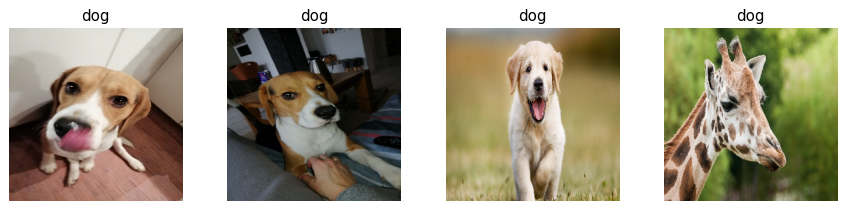

In [73]:
imgs = generator[0]
ncols, nrows = 4,8 # set according to the amount of pictures
fig = plt.figure( figsize=(ncols*3, nrows*3), dpi=90)
for i, prediction in enumerate(predictions):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(imgs[i])
    categ = 'dog' if prediction[0]>0.5 else 'cat'
    plt.title( f'{categ}')
    plt.axis('off')


In [6]:

from PIL import Image
dir = os.listdir('./Cat')
for i in dir:
  m = Image.open(f'Cat/{i}')
  m.load()
  print(i)

FileNotFoundError: [WinError 3] Das System kann den angegebenen Pfad nicht finden: './Cat'